# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 8
# Ensemble methods

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave


Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
import warnings
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
import random
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import KFold
from operator import itemgetter
import time

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 10)
%matplotlib inline

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between a collision that produces Higgs bosons and collisions thats produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle colision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.


### Read Data & Remove Whitespace from Column Names

In [2]:
# read in the training and test data
path = '/Volumes/EMTEC/Harvard/HW8/Data/' #'D:/Harvard/HW8/Data/' # 

df_train = pd.read_csv(path + 'Higgs_train.csv')
df_test = pd.read_csv(path + 'Higgs_test.csv')

def remove_whitespace(x, joiner='_'):
    '''
    Adapted from: 
    https://www.safaribooksonline.com/library/view/python-business-intelligence/9781785287466/ch02s17.html
    
    Helper function to remove any blank space from a string
    x: a string
    '''
    try:
        # Remove spaces inside of the string
        x = joiner.join(x.split())

    except:
        pass
    return x

df_train.columns = [remove_whitespace(col) for col in df_train.columns]
df_test.columns = [remove_whitespace(col) for col in df_test.columns]

df_train.head()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,...,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.376816,-1.583727,-1.707552,0.990897,0.114397,...,1.359610,0.964809,1.309991,1.083203,1.0
1,0.707330,0.087603,-0.399742,0.918742,-1.229936,...,1.157820,2.215780,1.189586,0.937976,1.0
2,0.617290,0.265839,-1.345227,1.154581,1.036646,...,0.927720,1.371080,0.981672,0.917436,1.0
3,0.850992,-0.380876,-0.071264,1.468704,-0.795133,...,1.353453,1.455383,0.994682,0.953553,1.0
4,0.767540,-0.691572,-0.040191,0.614843,0.143765,...,1.373222,0.601492,0.918621,0.957063,0.0


In [3]:
# describe the data
print('''
Training Shape:
-----------------------------------------------
%s

Testing Shape:
-----------------------------------------------
%s

Description of Training Data:
-----------------------------------------------
%s

Columns:
-----------------------------------------------
%s
''' %(df_train.shape, df_test.shape, df_train.describe(), df_train.columns))


Training Shape:
-----------------------------------------------
(5000, 29)

Testing Shape:
-----------------------------------------------
(5000, 29)

Description of Training Data:
-----------------------------------------------
         lepton_pT   lepton_eta   lepton_phi  missing_energy_magnitude  \
count  5000.000000  5000.000000  5000.000000               5000.000000   
mean      0.978640    -0.014242    -0.018940                  1.005780   
std       0.547021     1.011918     0.997988                  0.591891   
min       0.275063    -2.411601    -1.741953                  0.010021   
25%       0.586819    -0.763889    -0.877757                  0.581321   
50%       0.845502    -0.009307    -0.016055                  0.903459   
75%       1.219481     0.725066     0.836731                  1.303024   
max       5.325748     2.427076     1.742681                  6.259064   

       missing_energy_phi     ...             m_jlv         m_bb        m_wbb  \
count         5000.000

In [4]:
# separate x from y for train and test
predictors = [col for col in df_train.columns if col != 'class']
x_train, y_train = df_train[predictors], df_train[['class']]
x_test, y_test = df_test[predictors], df_test['class']

## Question 1 (2pt): Single Decision Tree
We start by building a basic model which we will use as our base model for comparison. 

1. Fit a decision tree model to the training set and report the classification accuracy of the model on the test set. Use 5-fold cross-validation to choose the (maximum) depth for the tree. You will use the max_depth you find here throughout the homework. 


### Finding Best `max_depth` of Single Decision Tree via 5-Fold Cross-Validation 


Optimal Depth of Tree = 5


Decision Tree w/ Best Depth
----------------------------------
Training Score = 0.6820
Testing Score = 0.6456



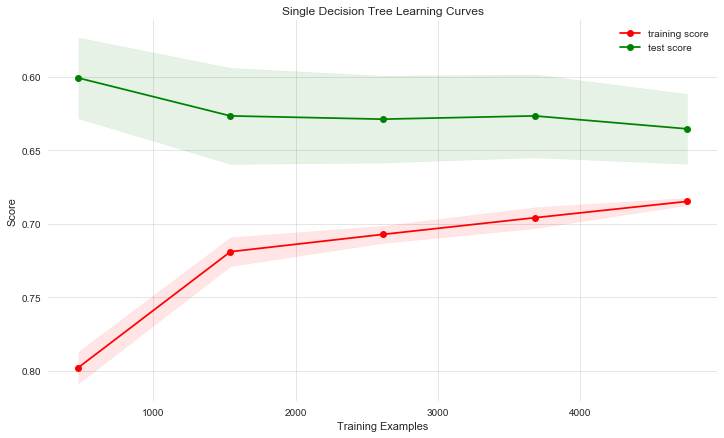

In [5]:
def plot_learning_curve(mod, X, y, cv, n_jobs, title, ax=None, invert=True):
    '''
    Generates a simple plot of test & training learning curves.
    Inspired from https://github.com/cs109/a-2017/blob/master/Sections/Standard/section_9_student.ipynb
    and from lecture/section.
    
    Inputs:
    -----------------------------------------------------------------
     mod: model for which learning curve must be plotted
     X: predictor data 
     y: true labels
     cv: number cross validation iterations
     n_jobs: number of cores (-1 for all available)
     ax: optional matplotlib Axes object on which to plot
    
    Outputs:
    -----------------------------------------------------------------
     None: plotted learning curves
    '''
    plt.style.use('seaborn-whitegrid')
    
    train_sizes, train_scores, test_scores = learning_curve(mod, X=X, y=y_train.values.ravel(), cv=20, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if ax == None: fig, ax = plt.subplots(figsize=(12, 7))
    if invert: ax.invert_yaxis()
        
    ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label='training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='g', label='test score')
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.grid(alpha=0.5)
    sns.despine(bottom=True, left=True)
    ax.legend(loc='best')
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    return None


# run GridSearchCV over 5 folds of KFolds CV
param_grid = {'max_depth':range(1, 15)}
kfolds = KFold(n_splits=5, shuffle=True, random_state=777)
best_depths = []

# use kfolds to identify best depth of tree
for train, val in kfolds.split(x_train):
    _xtrain, _ytrain = x_train.iloc[train], y_train.iloc[train].values.ravel()
    _xval, _yval = x_train.iloc[val], y_train.iloc[val].values.ravel()
    
    # perform gridsearch over 1-15 for max_depth
    dtree = DecisionTreeClassifier()
    clf = GridSearchCV(dtree, param_grid)
    clf.fit(_xtrain, _ytrain)

    best_depths.append(clf.best_params_)

# take average of best max_depth's from cross validation
best_depths_df = pd.DataFrame(best_depths, index=range(5))
best_depth = round(np.mean(best_depths_df.max_depth), 0)

print('''
Optimal Depth of Tree = %i
''' %best_depth)

dtree = DecisionTreeClassifier(max_depth=best_depth)
dtree.fit(x_train, y_train)

train_score = dtree.score(x_train, y_train.values.ravel())
test_score = dtree.score(x_test, y_test.values.ravel())

print('''
Decision Tree w/ Best Depth
----------------------------------
Training Score = %.4f
Testing Score = %.4f
''' %(train_score, test_score))

mod  = DecisionTreeClassifier(max_depth=best_depth)
title = 'Single Decision Tree Learning Curves'

plot_learning_curve(mod, x_train, y_train.values.ravel(), cv=10, n_jobs=-1, title=title)

### Optimal `max_depth` of Decision Tree

Cross validation was performed on five separate samples of the training data using `sklearn`'s `GridSearchCV` and `KFold`.  At each iteration the grid search uses cross-validation to empirically find the best depth from options between 1 and 15, and after the five iterations an average was taken (and made into an integer) to represent a `best_depth = 5` to use later in the notebook.

## Question 2 (15pt): Dropout-based Approach
We start with a simple method inspired from the idea of 'dropout' in machine learning, where we fit multiple decision trees on random subsets of predictors, and combine them through a majority vote. The procedure is described below.

- For each predictor in the training sample, set the predictor values to 0 with probability $p$  (i.e. drop the predictor by setting it to 0). Repeat this for $B$ trials to create $B$ separate training sets.


- Fit decision tree models $\hat{h}^1(x), \ldots, \hat{h}^B(x) \in \{0,1\}$ to the $B$ training sets. 

- Combine the decision tree models into a single classifier by taking a majority vote:
$$
\hat{H}_{maj}(x) \,=\, majority\Big(\hat{h}^1(x), \ldots, \hat{h}^B(x)\Big).
$$


We shall refer to the combined classifier as an ** *ensemble classifier* **. Implement the described dropout approach, and answer the following questions:
1. Apply the dropout procedure with $p = 0.5$ for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracy of the combined classifier. Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.
- Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.
- Apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees. How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?
[hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

### Acquire Optimal `n_estimators` for Drop-out Ensemble

In [6]:
def drop_random_predictors(xtrain, xtest, pct_include):
    '''
    A function that takes in X matrices for both the training and
    test set, then randomly selects pct_include percentage of the
    predictors supplied.  
    
    Inputs:
    -----------------------------------------------------------------
     xtrain: unmodified training predictors
     xtest: unmodified testing predictors
     pct_include: percentage of predictors to keep in transformation
    
    Outputs:
    -----------------------------------------------------------------
     xtrain: transformed predictors w/ `pct_include` features un-muted
     xtest: transformed predictors w/ `pct_include` features un-muted
    '''
    predictors = xtrain.columns
    xtrain, xtest = xtrain.copy(), xtest.copy()
    n_include = int(round(pct_include * len(predictors), 0))
    
    # enumerate new predictors (ie not left out)
    new_predictors = [predictors[i] for i in random.sample(range(len(predictors)), n_include)]
    drop_predictors = [col for col in predictors if col not in new_predictors]
    
    # set predictors to drop to zero
    xtrain[drop_predictors] = 0
    xtest[drop_predictors] = 0
    
    return xtrain, xtest

def drop_random_ensemble_classifier(x_train, x_test, y_train, y_test, B_iterations, pct_include, max_depth=best_depth):
    '''
    A function that uses the `drop_random_predictors` function defined above
    to randomly mute some percentage of the predictors, then fits a decision tree
    for `B_iterations`, caches their predictions and scores, then takes a majority
    vote for the prediction.
    
    Inputs:
    -----------------------------------------------------------------
     x_train: unmodified training predictors
     x_test: unmodified testing predictors
     B_iterations: arbitrary number of trees to fit & new data to generate
     pct_include: percentage of predictors to be used in each iteration of model
    
    Outputs:
    -----------------------------------------------------------------
     yhat_and_score: dictionary of the ensemble's yhat and score for both 
      train and test data
    '''
    yhats_train, yhats_test = {}, {}
    for i in range(B_iterations):
        # set random predictors to zero with 0.50 probability
        _xtrain, _xtest = drop_random_predictors(x_train, x_test, pct_include)

        # fit decision tree to new dataset
        dtree = DecisionTreeClassifier(max_depth=max_depth)
        dtree.fit(_xtrain, y_train.values.reshape(-1, 1))

        # get yhats of train and test sets
        yhat_train = dtree.predict(_xtrain)
        yhats_train['yhat_trial_' + str(i)] = yhat_train
        
        yhat_test = dtree.predict(_xtest)
        yhats_test['yhat_trial_' + str(i)] = yhat_test

    # get majority votes for both train and test
    majority_vote_train = pd.DataFrame(yhats_train).mode(axis=1)
    majority_vote_test = pd.DataFrame(yhats_test).mode(axis=1)
    
    # get accuracy on train and test
    score_test = 1 - zero_one_loss(y_test.astype(int), majority_vote_test[0].values.astype(int))
    score_train = 1 - zero_one_loss(y_train.astype(int), majority_vote_train[0].values.astype(int))
    
    # bundle for return
    yhat_and_score = {'train': {'yhat':majority_vote_train, 'score':score_train},
                     'test': {'yhat':majority_vote_test, 'score':score_test}}
    
    return yhat_and_score



# part 1 check ensemble at different tree depths using p = 0.50
n_trees = [2, 4, 8, 16, 32, 64, 128, 256] 
n_estimators = []

# iteratively determine number of estimators that is optimal
for i, trees in enumerate(n_trees):
    # train ensemble of decision trees (using best depth) & varying the number of estimators/trees
    yhat_score = drop_random_ensemble_classifier(x_train, x_test, 
                                                 y_train, y_test, 
                                                 B_iterations=trees, 
                                                 pct_include=0.5, 
                                                 max_depth=best_depth)

    # cache data from iteration
    n_estimators.append({'train_score':yhat_score['train']['score'], 
                         'test_score':yhat_score['test']['score'],
                         'n_trees':trees})
    
n_estimators_df = pd.DataFrame(n_estimators).set_index('n_trees')

best_n_estimators = n_estimators_df['test_score'].idxmax()
print('Best Number of Trees = %i\n' %best_n_estimators)
n_estimators_df

Best Number of Trees = 128



,test_score,train_score
n_trees,,
2,0.5832,0.6162
4,0.6352,0.6902
8,0.6612,0.7034
16,0.6642,0.7172
32,0.6766,0.7214
64,0.6872,0.7336
128,0.6892,0.7302
256,0.6868,0.7324


### Acquire Optimal Drop-out Rate of Features

In [7]:
# part 2
probabilities = [.1, .3, .5, .7, .9]
probs = []

for i, prob in enumerate(probabilities):
    # do same using different probabilities
    yhat_score = drop_random_ensemble_classifier(x_train, x_test, 
                                                 y_train, y_test, 
                                                 B_iterations=64, #holding trees = 64
                                                 pct_include=prob, #test prob
                                                 max_depth=best_depth) #found best depth

    # cache data from iteration
    probs.append({'train_score':yhat_score['train']['score'], 
                  'test_score':yhat_score['test']['score'],
                  'probability':prob})

    
probs_df = pd.DataFrame(probs, index=probabilities).set_index('probability')

best_prob = probs_df['test_score'].idxmax()
print('Best Percentage of Features = %.5f\n' %best_prob)
probs_df

Best Percentage of Features = 0.30000



,test_score,train_score
probability,,
0.1,0.5956,0.6252
0.3,0.6838,0.7354
0.5,0.6772,0.7304
0.7,0.6694,0.7066
0.9,0.6456,0.6820


### Visualize Performance

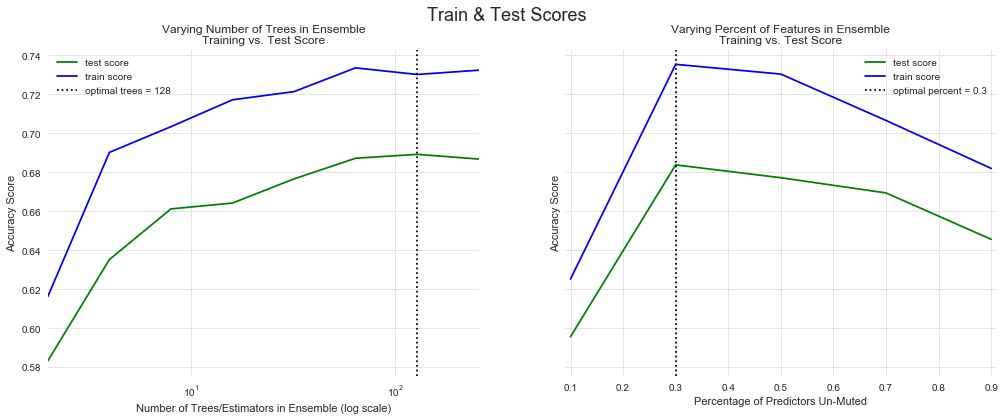

In [8]:
# visualize the learning curves and accuracy scores at various values for tuning parameters

fig, axes = plt.subplots(1, 2, figsize=(17, 6), sharey=True)
ax = axes[0]
x = n_estimators_df.index.values
ax.plot(x, n_estimators_df.test_score, c='green', label='test score')
ax.plot(x, n_estimators_df.train_score, c='blue', label='train score')
ax.axvline(best_n_estimators, c='black', linestyle=':', 
           label='optimal trees = ' + str(best_n_estimators))
ax.set_title('Varying Number of Trees in Ensemble\nTraining vs. Test Score')
ax.set_xlabel('Number of Trees/Estimators in Ensemble (log scale)')
ax.set_ylabel('Accuracy Score')
ax.legend(loc='best')
ax.semilogx()
ax.grid(alpha=0.5)
ax.set_xlim([2, 256+1])
plt.style.use('seaborn-whitegrid')
sns.despine(left=True, bottom=True)

ax = axes[1]
x = probs_df.index.values
ax.plot(x, probs_df.test_score, c='green', label='test score')
ax.plot(x, probs_df.train_score, c='blue', label='train score')
ax.axvline(best_prob, c='black', linestyle=':', 
           label='optimal percent = ' + str(best_prob))
ax.set_xlim([.09, .91])
ax.set_title('Varying Percent of Features in Ensemble\nTraining vs. Test Score')
ax.set_xlabel('Percentage of Predictors Un-Muted')
ax.set_ylabel('Accuracy Score')
ax.legend(loc='best')
ax.grid(alpha=0.5)
plt.style.use('seaborn-whitegrid')
sns.despine(left=True, bottom=True)

plt.suptitle('Train & Test Scores', size=18)

### Summarize Best Drop-out Ensemble Model

In [9]:
# use best settings on ensemble model and review performance
yhat_score = drop_random_ensemble_classifier(x_train, x_test, 
                                             y_train, y_test, 
                                             B_iterations=64,  
                                             pct_include=best_prob, 
                                             max_depth=best_depth)
print('''
Dropout Ensemble w/ Optimized max_features & n_estimators 
----------------------------------
Training Score = %.4f
Testing Score = %.4f
''' %(yhat_score['train']['score'], yhat_score['test']['score']))


Dropout Ensemble w/ Optimized max_features & n_estimators 
----------------------------------
Training Score = 0.7278
Testing Score = 0.6660



### Does Increasing the Number of Trees Impacts Test Performance?

Increasing the number of trees in the ensemble does improve performance, yet it appears to have diminishing returns.  It is shown in the plot that both the training and test scores improve when adding trees where there are fewer than 32, yet this improvement diminishes and disappears at higher numbers.  Single trees (especially of large depths) tend to over-fit the training data and exhibit low bias and high variance.  The drop-out ensemble classifier reduces some of this variance by aggregating many trees together.


### How Drop-out Rate on Features Influences Bias-Variance Trade-off

At lower values for the drop-out rate high bias dominates the model; at higher values for the drop-out rate high variance dominates the model.  This reinforces the intuition that there exist some strong predictors and some not as much, meaning low drop-out rates (e.g. 10%) will cause some trees to be trained on poor predictors while others are trained on strong predictors.  Some of these models will be spectacularly off since they're trained on poor predictors, thus the high bias in the final vote.   


### How Test Performance of Ensemble Compares with Single Decision Tree

The increase in the time it takes to tune and train an ensemble of many trees relative to training a single tree is offset by a gain in test accuracy.  It is observed that test accuracy improves from 64.54% for the single tree to 68.60% for the ensemble of trees using a random drop-out procedure (with optimal feature drop-out of 0.30).  The "best" number of trees is rather high and has a high computational cost, so 64 trees was used to expedite the process. 

## Question 3 (15pt): Random Forests

We now move to a more sophisticated ensemble technique, namely random forest:
1. How does a random forest approach differ from the dropout procedure described in Question 2? 
 
- Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

- Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier. 
  
- Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the  number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?  





### Find Optimal `n_estimators` for `RandomForestClassifier` via Cross-Validation 

In [10]:
# Q3 part 2
n_predictors = int(round(np.sqrt(len(x_train.columns))))

n_trees = [2, 4, 8, 16, 32, 64, 128, 256] 
diff_ntrees = []

for i, trees in enumerate(n_trees):
    # instantiate rf clf with different tree depth of base estimator
    rf = RandomForestClassifier(max_depth=None, #saving compute time, no reason not to let it ride
                                n_estimators=trees, 
                                max_features='sqrt', #to get sqrt(n_predictors)
                                n_jobs=-1,
                                oob_score=True,
                                random_state=777)
    rf.fit(x_train, y_train.values.ravel())
    
    # get scores
    score_train = rf.score(x_train, y_train.values.ravel())
    score_oob = rf.oob_score_
    score_test = rf.score(x_test, y_test.values.ravel())

    
    # cache data from iteration
    diff_ntrees.append({'train_score':score_train, 
                        'test_score':score_test, 'oob_score':score_oob})
    
diff_ntrees_df = pd.DataFrame(diff_ntrees, index=n_trees)
diff_ntrees_df.index.name = 'n_trees'

# does larger number of trees improve test accuracy of a rf model? 
# explain how ntrees effects train/test accuracy of rf clf
best_n_classifiers = diff_ntrees_df.test_score.idxmax()

print('Best n_estimators = %i\n' %best_n_classifiers)
diff_ntrees_df

Best n_estimators = 256



,oob_score,test_score,train_score
n_trees,,,
2,0.5296,0.5714,0.8470
4,0.5508,0.5972,0.9306
8,0.5794,0.6372,0.9800
16,0.6106,0.6616,0.9974
32,0.6474,0.6840,0.9998
64,0.6672,0.6868,1.0000
128,0.6846,0.6960,1.0000
256,0.6860,0.7020,1.0000


### Find Best `max_features` via `KFold` Cross-Validation

In [11]:
# Q3 part 4.0 - fixing n trees apply 5 fold CV to choose optimal value for n predictors
# Utility function to report best scores
def report(grid_scores, n_top=1):
    '''
    Modified from:
    http://scikit-learn.org/0.15/auto_examples/randomized_search.html
    '''
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


param_grid = {'max_features':np.arange(2, len(x_train.columns))}
kfolds = KFold(n_splits=5, shuffle=True, random_state=777)
param_df = {}
k = 1
for train, val in kfolds.split(x_train):
    print('Fold Number: %i' %k)
    _xtrain, _ytrain = x_train.iloc[train],  y_train.iloc[train]
    _xval, _yval = x_test.iloc[val], y_test.iloc[val]
    
    # gridsearch for best max_features setting for this fold
    rf = RandomForestClassifier(max_depth=None, 
                                n_estimators=64, 
                                n_jobs=-1,
                                oob_score=True,
                                random_state=777)
    grid = GridSearchCV(rf, param_grid=param_grid, n_jobs=-1)
    grid.fit(_xtrain, _ytrain.values.ravel())
    report(grid.grid_scores_)
    
    # cache best param
    param_df[k] = grid.best_params_
    
    k += 1
    
param_df = pd.DataFrame(param_df).T
param_df.index.name = 'k_fold'

best_n_features = int(param_df['max_features'].mean())
print('''
Best number of features after 5 fold CV = %i
'''%best_n_features)

param_df

Fold Number: 1
Model with rank: 1
Mean validation score: 0.679 (std: 0.003)
Parameters: {'max_features': 10}

Fold Number: 2
Model with rank: 1
Mean validation score: 0.682 (std: 0.018)
Parameters: {'max_features': 7}

Fold Number: 3
Model with rank: 1
Mean validation score: 0.680 (std: 0.005)
Parameters: {'max_features': 11}

Fold Number: 4
Model with rank: 1
Mean validation score: 0.673 (std: 0.009)
Parameters: {'max_features': 10}

Fold Number: 5
Model with rank: 1
Mean validation score: 0.691 (std: 0.006)
Parameters: {'max_features': 9}


Best number of features after 5 fold CV = 9



,max_features
k_fold,
1,10
2,7
3,11
4,10
5,9


### Fit `RandomForestClassifier` Using Best Parameters

In [12]:
# Q3 Part 4.2 re-fit using best parameters 
rf = RandomForestClassifier(max_depth=None,
                            max_features=best_n_features,
                            n_estimators=64, 
                            n_jobs=-1,
                            oob_score=True,
                            random_state=777)
rf.fit(x_train, y_train.values.reshape(-1, 1))

print('''
Random Forest w/ Best Parameters
----------------------------------
Training Score = %.5f
OOB Score = %.5f
Testing Score = %.5f
''' %(rf.score(x_train, y_train.values.reshape(-1, 1)), rf.oob_score_, rf.score(x_test, y_test.values.reshape(-1, 1))))


Random Forest w/ Best Parameters
----------------------------------
Training Score = 1.00000
OOB Score = 0.67300
Testing Score = 0.69420



### Visualize Performance & Learning Curves

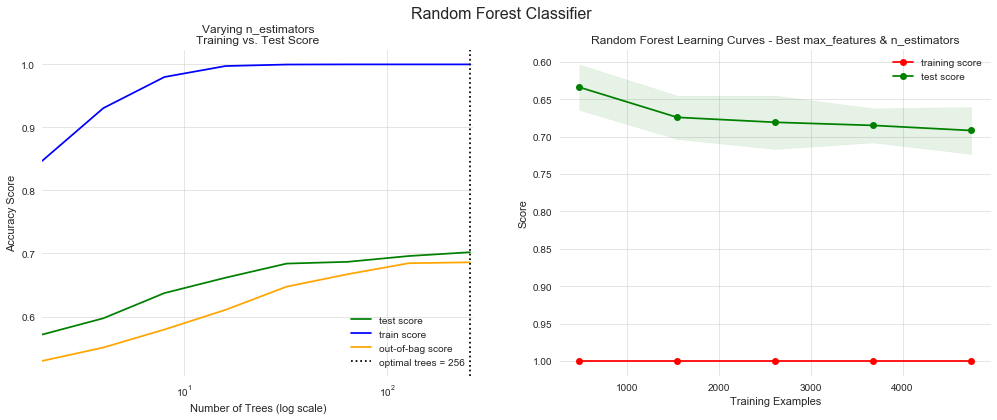

In [13]:
# summary plots of learning curves and scores
fig, axes = plt.subplots(1, 2, figsize=(17, 6))

ax = axes[0]
x = diff_ntrees_df.index.values
ax.plot(x, diff_ntrees_df.test_score, c='green', label='test score')
ax.plot(x, diff_ntrees_df.train_score, c='blue', label='train score')
ax.plot(x, diff_ntrees_df.oob_score, c='orange', label='out-of-bag score')
ax.axvline(diff_ntrees_df['test_score'].idxmax(), c='black', linestyle=':', 
           label='optimal trees = ' + str(best_n_classifiers))
ax.set_title('Varying n_estimators\nTraining vs. Test Score')
ax.set_xlabel('Number of Trees (log scale)')
ax.set_ylabel('Accuracy Score')
ax.legend(loc='best')
ax.semilogx()
ax.grid(alpha=0.5)
ax.set_xlim([2, 256+10])
plt.style.use('seaborn-whitegrid')
sns.despine(left=True, bottom=True)

mod = RandomForestClassifier(max_depth=None, #arbitrarily large
                            max_features=best_n_features,
                            n_estimators=best_n_classifiers, 
                            n_jobs=-1,
                            oob_score=False, #don't need for plotting
                            random_state=777)
title = 'Random Forest Learning Curves - Best max_features & n_estimators'

plot_learning_curve(mod, x_train, y_train.values.ravel(), cv=10, n_jobs=-1, title=title, ax=axes[1])

plt.suptitle('Random Forest Classifier', size=16)

### Plot Learning Curves Over Various `n_estimators`

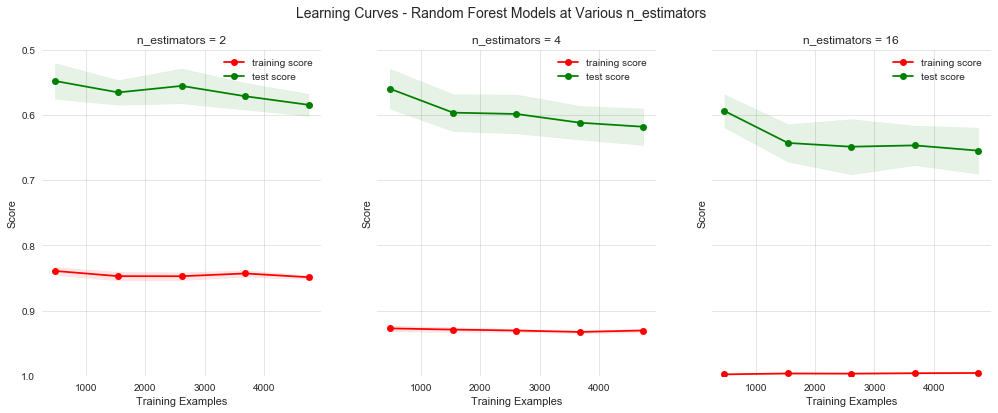

In [14]:
# plot different valuese for n_estimators and max_features
n_trees = [2, 4, 16]
fig, axes = plt.subplots(1, 3, figsize=(17, 6), sharey=True)
for i, trees in enumerate(n_trees):
    ax = axes[i]
    mod  = RandomForestClassifier(max_depth=None, 
                                  max_features=best_n_features,
                                  n_estimators=trees, 
                                  n_jobs=-1,
                                  oob_score=False, #don't need for plotting
                                  random_state=777)
    title = 'n_estimators = ' + str(round(trees, 0))
    plot_learning_curve(mod, x_train, y_train.values.ravel(), cv=10, n_jobs=-1, title=title, invert=True, ax=ax)

    
plt.suptitle('Learning Curves - Random Forest Models at Various n_estimators', size=14)
ax.set_ylim([.5, 1])
ax.invert_yaxis()

### How Random Forest Differs from the Bagging Dropout Procedure

Random Forest is a uniquely modified form of bagging that creates ensembles of decision trees in such a way that the trees maximize independence from one another.  This is done via two mechanisms: by boostrapping observations and by selecting a subset of predictors to consider at each split in each tree.  Compare this with the dropout ensemble procedure which selects which features to include *at the start of fitting any individual tree*.  Random Forest chooses which features to include *at each split in each tree*, thus any predictor that is excluded at the first split is still eligible to be included at the second split, third split, and so on. This effectively de-correlates the trees by creating trees wherein the closer-to-root nodes are less dominated by the strongest predictors.


### Do Larger Numbers of Trees Improve Test Accuracy On Random Forest Model?

Training a larger number of `n_estimators` on a `RandomForestClassifier` does appear to improve test accuracy, yet similar to the drop-out ensemble model the benefit exhibits diminishing returns.  Both test and out-of-bag accuracy scores increased at a rapid pace on models trained using `n_estimators` in the range of 2 through 32.  Beyond this point the increase in accuracy slows and reaches a maximum at 256.  

Using such a large number of models would imply a considerable computational cost, so knowing that we can use a lower value for this parameter with little-to-nothing lost in terms of accuracy is helpful when time is more valuable than a slight increase in accuracy.  

RF models with higher values for `n_estimators` typically see a reduction in variance compared to their lower `n_estimators` counterparts.  Aggregating many trees will reduce the variance while keeping the bias little changed.  The effect of aggregation is amplified by RF's bootstrap sampling of records and random selection of the number of features to include at each step. 


### Comparing Random Forest to the Drop-out Ensemble

The Random Forest model's test performance is slightly better than that of the drop-out ensemble.  The drop-out ensemble produced a test score of 68.60% while the Random Forest model produced a test score of 69.40%.  It is evident that the incremental algorithm design choices made with the `RandomForestClassifier` as compared with the on the Drop-out Ensemble were enough to achieve a slight increase in test accuracy.  

## Question 4 (15pt): Boosting

We next compare the random forest model with the approach of boosting:


1. Apply the AdaBoost algorithm to fit an ensemble of decision trees. Set the learning rate to 0.05, and try out different tree depths for the base learners: 1, 2, 10, and unrestricted depth.  Make a plot of the training accuracy of the ensemble classifier as a function of tree depths. Make a similar plot of the test accuracies as a function of number of trees (say $2, 4, 8, 16, \ldots, 256$).
- How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.
- How does the tree depth of the base learner impact the training and test performance? Would you recommend the same strategy for boosting? Explain your answer.
- Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4? 



### Apply Cross-Validation To Find Best `max_depth`

In [15]:
from sklearn.ensemble import AdaBoostClassifier 
from IPython import display

depths = [1, 2, 10, 999]
diff_depths = []

for i, depth in enumerate(depths):
    # apply adaboost to fit ensemble of dtrees with learning rate .05
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), 
                             learning_rate=.05, 
                             n_estimators=100)
    
    # save CV scores
    scores = cross_val_score(ada, X=x_train, y=y_train.values.ravel(), cv=5, n_jobs=-1)
    ada.fit(x_train, y_train.values.ravel())
    test_score = ada.score(x_test, y_test.values.ravel())
    train_score = ada.score(x_train, y_train.values.ravel())
    val_score = scores.mean()
    
    # cache data from iteration
    diff_depths.append({'depth':depth, 'train_score':train_score, 'test_score':test_score, 'val_score':val_score})

# identify best depth
diff_depths_df = pd.DataFrame(diff_depths).set_index('depth')
best_depth = diff_depths_df['test_score'].idxmax()
print('Best depth of Adaboosted Decision Tree = %i' %best_depth)
diff_depths_df

Best depth of Adaboosted Decision Tree = 2


,test_score,train_score,val_score
depth,,,
1,0.6594,0.6556,0.644208
2,0.6912,0.6992,0.677407
10,0.6338,1.0000,0.634795
999,0.5976,1.0000,0.589805


### Apply Cross-Validation To FInd Best `n_estimators`

In [16]:
n_estimators = [2, 4, 8, 16, 32, 64, 128, 256]
diff_n_trees = []

for i, n_trees in enumerate(n_estimators):
    # apply adaboost to fit ensemble of dtrees with learning rate .05
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_depth), 
                             learning_rate=.05, 
                             n_estimators=n_trees)
    
    # save CV scores
    scores = cross_val_score(ada, X=x_train, y=y_train.values.ravel(), cv=5, n_jobs=-1)
    ada.fit(x_train, y_train.values.ravel())
    test_score = ada.score(x_test, y_test.values.ravel())
    train_score = ada.score(x_train, y_train.values.ravel())
    val_score = scores.mean()
    
    # cache data from iteration
    diff_n_trees.append({'n_trees':n_trees, 'train_score':train_score, 'test_score':test_score, 'val_score':val_score})

# id best n_trees
diff_n_trees_df = pd.DataFrame(diff_n_trees).set_index('n_trees')
best_ntrees = diff_n_trees_df['test_score'].idxmax()
print('Best n_classifiers for Adaboost = %i' %best_ntrees)
diff_n_trees_df

Best n_classifiers for Adaboost = 256


,test_score,train_score,val_score
n_trees,,,
2,0.6430,0.6386,0.628810
4,0.6430,0.6386,0.624806
8,0.6468,0.6452,0.626609
16,0.6568,0.6600,0.642606
32,0.6650,0.6660,0.647806
64,0.6836,0.6852,0.667806
128,0.6874,0.7090,0.681807
256,0.6940,0.7402,0.685004


### Visualize Performance

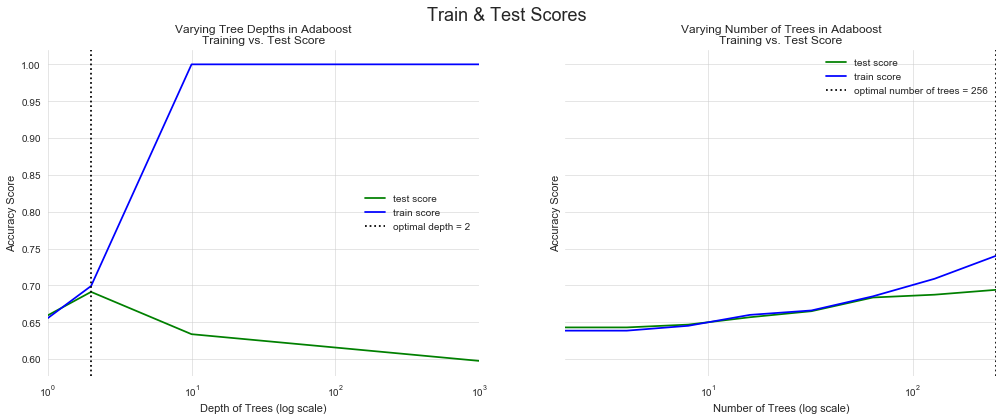

In [17]:
# make plots of training accuracy of ensemble classifier @ tree depths/trees
fig, axes = plt.subplots(1, 2, figsize=(17, 6), sharey=True)

ax = axes[0]
x = diff_depths_df.index.values
ax.plot(x, diff_depths_df.test_score, c='green', label='test score')
ax.plot(x, diff_depths_df.train_score, c='blue', label='train score')
ax.axvline(best_depth, c='black', linestyle=':', 
           label='optimal depth = ' + str(best_depth))
ax.set_title('Varying Tree Depths in Adaboost\nTraining vs. Test Score')
ax.set_xlabel('Depth of Trees (log scale)')
ax.set_ylabel('Accuracy Score')
ax.legend(loc='best')
ax.semilogx()
ax.grid(alpha=0.5)
ax.set_xlim([0, 1000])
plt.style.use('seaborn-whitegrid')
sns.despine(left=True, bottom=True)

ax = axes[1]
x = diff_n_trees_df.index.values
ax.plot(x, diff_n_trees_df.test_score, c='green', label='test score')
ax.plot(x, diff_n_trees_df.train_score, c='blue', label='train score')
ax.axvline(best_ntrees, c='black', linestyle=':', 
           label='optimal number of trees = ' + str(best_ntrees))
ax.set_title('Varying Number of Trees in Adaboost\nTraining vs. Test Score')
ax.set_xlabel('Number of Trees (log scale)')
ax.set_ylabel('Accuracy Score')
ax.semilogx()
ax.legend(loc='best')
ax.grid(alpha=0.5)
ax.set_xlim([0, 256+1])
plt.style.use('seaborn-whitegrid')
sns.despine(left=True, bottom=True)

plt.suptitle('Train & Test Scores', size=18)

### Summarize Best Model

In [18]:
# apply adaboost to fit ensemble of dtrees with learning rate .05
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_depth), 
                         learning_rate=.05, 
                         n_estimators=best_ntrees,
                         random_state=777)
ada.fit(x_train, y_train.values.reshape(-1, 1))

# get yhat and score for both train and test for RF classifier
yhat_train = ada.predict(x_train)
yhat_test = ada.predict(x_test)

# get scores
score_train = ada.score(x_train, y_train.values.reshape(-1, 1))
score_test = ada.score(x_test, y_test.values.reshape(-1, 1))

print('''
Adaboost w/ Best Parameters
----------------------------------
Training Score = %.5f
Testing Score = %.5f
''' %(score_train, score_test))


Adaboost w/ Best Parameters
----------------------------------
Training Score = 0.74020
Testing Score = 0.69540



### Plot Learning Curves Over Varying Values of `n_estimators`

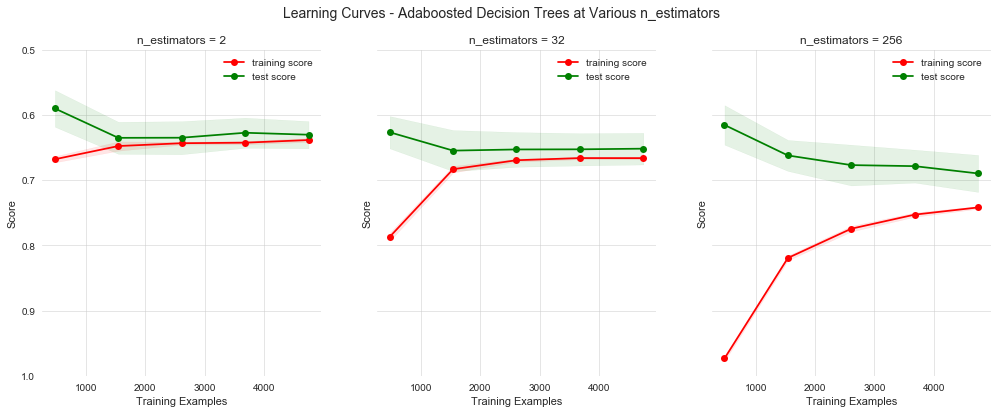

In [19]:
# plot learning curves for different values for n_estimators
n_trees = [2, 32, 256]
fig, axes = plt.subplots(1, 3, figsize=(17, 6), sharey=True)
for i, trees in enumerate(n_trees):
    ax = axes[i]
    mod  = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_depth), 
                         learning_rate=.05, 
                         n_estimators=trees,
                         random_state=777)
    title = 'n_estimators = ' + str(round(trees, 0))
    plot_learning_curve(mod, x_train, y_train.values.ravel(), cv=10, n_jobs=-1, title=title, invert=True, ax=ax)

plt.suptitle('Learning Curves - Adaboosted Decision Trees at Various n_estimators', size=14)
ax.set_ylim([.5, 1])
ax.invert_yaxis()

## How Number of Trees in Adabost Influences Performance

As the number of trees increases both training and test scores increase as well.  This improvement follows intuition in that each iteration of fitting re-weights the data to perform better on the observations that it misclassified previously.


## How the Tree Depth of the Base Learning Model Impacts Performance

As the tree depth of the base classifier increases we observe that the `AdaBoostClassifier` model performs well on the training data while its test performance declines.  The model appears to be over-fitting to the data on depths greater than 2.  Using Adaboost it is not recommended to allow the maximum tree depth to be unrestricted as in Random Forest, but rather to use a smaller value for `max_depth` found through cross-validation.  The reasoning behind this is that RF models are complex (i.e. many trees with unrestricted depth) and have low bias yet high variance while Adaboost uses simpler models (i.e. many trees with depths set to low values) that exhibit low variance and high bias.  Thus it becomes apparent that bagging is geared more towards reducing the variance of a complex model while boosting is better suited for reducing the bias of a simple model. 


## Comparison of Random Forest vs. Adaboost

While Random Forest reduces a complex model's variance, boosting reduces a simple model's bias.  Random Forest reduces the variance in the underlying models by de-correlating the trees through its random, iterative selection of features at each split in each tree in the ensemble.  In contrast, Adaboost is designed to use successively deployed weak models to iteratively improve on areas of weak prediction (e.g. bias) yielded in previous iterations.  In general, boosting is used to correct the bias in a large number of under-fitting models; random forest is used to correct the variance in a large number of over-fitting models.

Comparing the performance of the two approaches it is shown that Adaboost and Random Forest have very similar test performances of 69.5% and 69.4%, respectively.  

## Question 5 (3pt): Meta-classifier

We have so far explored techniques that grow a collection of trees either by creating multiple copies of the original training set, or through a sequential procedure, and then combines these trees into a single classifier. Consider an alternate scenario where you are provided with a pre-trained collection of trees, say from different participants of a data science competition for Higgs boson discovery. What would be a good strategy to combine these pre-fitted trees into a single powerful classifier? Of course, a simple approach would be to take the majority vote from the individual trees. Can we do better than this simple combination strategy?

A collection of 100 decision tree classifiers is provided in the file `models.npy` and can be loaded into an array by executing:

`models = np.load('models.npy')`

You can make predictions using the $i^\text{th}$ model on an array of predictors `x` by executing:

`model[i].predict(x)`  &nbsp;&nbsp;&nbsp;
or &nbsp;&nbsp;&nbsp;
`model[i].predict_proba(x)`

and score the model on predictors `x` and labels `y` by using:

`model[i].score(x, y)`.

1. Implement a strategy to combine the provided decision tree classifiers, and compare the test perfomance of your approach with the majority vote classifier. Explain your strategy/algorithm.



### Develop Algorithm to Combine Models

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

models = np.load(path + 'models.npy', encoding='latin1')

def stacked_dataset(models, x_train, y_train):
    '''
    For each model generates predicted probabilities using a new training set
    and adds as a column to the previous ones
    '''
    df = pd.DataFrame()
    for i, model in enumerate(models):
        # get training prediction probabilities
        probs = model.predict_proba(x_train.values)[:, 1]
        scores = np.repeat(model.score(x_train, y_train.values.reshape(-1, 1)), len(probs))#; print(scores)
        probs = [(1+prob) * weight for prob, weight in zip(probs, scores)]
        
        # save probabilities from each mode, add as a feature
        new_df = pd.DataFrame.from_dict({'wtd_probability_model_'+str(i):probs, 'y':y_train.values.ravel()}, 
                                        orient='columns').set_index('y')
        df = pd.concat([df, new_df['wtd_probability_model_'+str(i)]], axis=1)
        
    return df

# get train/test data transformed
train_df = stacked_dataset(models, x_train, y_train)
test_df = stacked_dataset(models, x_test, y_test)

# transform data w/ standard scaler
scaler = StandardScaler()
scaler.fit(train_df)
x_train_stack = scaler.transform(train_df)
x_test_stack = scaler.transform(test_df)

# fit Adaboost model
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), 
                         learning_rate=.05, 
                         n_estimators=1000,
                         random_state=777)
ada.fit(x_train_stack, y_train.values.reshape(-1, 1))

# get scores
train_score = ada.score(x_train_stack, y_train)
test_score = ada.score(x_test_stack, y_test)

print('''
Stacked Model Using Adaboost 
-------------------------------------
Training Score = %.5f
Testing Score = %.5f
''' %(train_score, test_score))


Stacked Model Using Adaboost 
-------------------------------------
Training Score = 0.72300
Testing Score = 0.68120



### Stacked Meta-Classifier Algorithm

Each model in the set is used to:
- produce a vector of probabilities $\hat p_{i,j}$ of a Higgs-Boson 
- derive scalar of the model's score $s_{i}$ for the model
- transmute score to a vector where $s_{i} = s_{i, j}$ equal to the length of the probabilities
- multiply the vectors together, while adding one to the probability
- normalize the features using `StandardScaler`

Each model produces one column vector that is added to a dataset that contains all of the models before it via the `pd.concat` function.  This dataframe is then treated as a feature set on which an `AdaBoostClassifier` is then trained.  

The idea behind multiplying the probability for a given observation by the score for the training model is simply to weight models that performed better (i.e. had a higher score) than the ones that performed worse.  Adding one is to avoid any zeros.  

The model performed relatively well, achieving a 68.1% testing score and a 72.3% training score.  

--- 

---

## APCOMP209a - Homework Question
​
We've worked with imputation methods on missing data in Homework 6.  We've worked with Decision Trees in HW7 and here.  Now let's see what happens if we try to work with Decision Trees and Missing Data at the same time! We'll be working with a dataset from the UCI Machine Learning Repository that uses a variety of wine chemical predictors to classify wines grown in the same region in Italy.  Each line represents 13 (mostly chemical) predictors of the response variable wine class, including things like alcohol content, hue , and phenols.  Unfortunately some of the predictor values were lost in measurement. Please load `wine_quality_missing.csv`. 
​
*Note*: As in HW6 be careful of reading/treating column names and row names in this data set.
​
​
1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the sklearn DecisionTreeClassifier and RandomForestClassifier.   Use cross-validation to find the optimal tree depth for each method.  Report the optimal tree-depth, overall classification rate and confusion matrix on the test set for each method.
2. Restart with a fresh copy of the data and impute the missing data via mean imputation.  Split the data 75-25 and again fit DecisionTreeClassifier and RandomForestClassifier using cross-validation to find the optimal tree depth.  Report the optimal tree depth, overall classification rate and confusion matrix on the test set for each method.  
3. Again restart with a fresh copy of the data but this time let's try something different.  As discussed in section, CART Decision Trees can take advantage of surrogate splits to handle missing data.  Split the data 75-25 and construct a **custom** decision tree model and train it on the training set with missing data. Report the optimal tree depth, overall classification rate and confusion matrix on the test set and compare your results to the Imputation and DecisionTree model results in part 1 & 2.


In [21]:
from __future__ import division, print_function

print(__doc__)

# Author: Peter Prettenhoer <peter.prettenhofer@gmail.com>
#
# License: BSD 3 clause

import matplotlib
matplotlib.use('TkAgg')

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.backends.backend_tkagg import NavigationToolbar2TkAgg
from matplotlib.figure import Figure
from matplotlib.contour import ContourSet

try:
    import tkinter as Tk
except ImportError:
    # Backward compat for Python 2
    import Tkinter as Tk

import sys
import numpy as np

from sklearn import svm
from sklearn.datasets import dump_svmlight_file
from sklearn.externals.six.moves import xrange

y_min, y_max = -50, 50
x_min, x_max = -50, 50


class Model(object):
    """The Model which hold the data. It implements the
    observable in the observer pattern and notifies the
    registered observers on change event.
    """

    def __init__(self):
        self.observers = []
        self.surface = None
        self.data = []
        self.cls = None
        self.surface_type = 0

    def changed(self, event):
        """Notify the observers. """
        for observer in self.observers:
            observer.update(event, self)

    def add_observer(self, observer):
        """Register an observer. """
        self.observers.append(observer)

    def set_surface(self, surface):
        self.surface = surface

    def dump_svmlight_file(self, file):
        data = np.array(self.data)
        X = data[:, 0:2]
        y = data[:, 2]
        dump_svmlight_file(X, y, file)


class Controller(object):
    def __init__(self, model):
        self.model = model
        self.kernel = Tk.IntVar()
        self.surface_type = Tk.IntVar()
        # Whether or not a model has been fitted
        self.fitted = False

    def fit(self):
        print("fit the model")
        train = np.array(self.model.data)
        X = train[:, 0:2]
        y = train[:, 2]

        C = float(self.complexity.get())
        gamma = float(self.gamma.get())
        coef0 = float(self.coef0.get())
        degree = int(self.degree.get())
        kernel_map = {0: "linear", 1: "rbf", 2: "poly"}
        if len(np.unique(y)) == 1:
            clf = svm.OneClassSVM(kernel=kernel_map[self.kernel.get()],
                                  gamma=gamma, coef0=coef0, degree=degree)
            clf.fit(X)
        else:
            clf = svm.SVC(kernel=kernel_map[self.kernel.get()], C=C,
                          gamma=gamma, coef0=coef0, degree=degree)
            clf.fit(X, y)
        if hasattr(clf, 'score'):
            print("Accuracy:", clf.score(X, y) * 100)
        X1, X2, Z = self.decision_surface(clf)
        self.model.clf = clf
        self.model.set_surface((X1, X2, Z))
        self.model.surface_type = self.surface_type.get()
        self.fitted = True
        self.model.changed("surface")

    def decision_surface(self, cls):
        delta = 1
        x = np.arange(x_min, x_max + delta, delta)
        y = np.arange(y_min, y_max + delta, delta)
        X1, X2 = np.meshgrid(x, y)
        Z = cls.decision_function(np.c_[X1.ravel(), X2.ravel()])
        Z = Z.reshape(X1.shape)
        return X1, X2, Z

    def clear_data(self):
        self.model.data = []
        self.fitted = False
        self.model.changed("clear")

    def add_example(self, x, y, label):
        self.model.data.append((x, y, label))
        self.model.changed("example_added")

        # update decision surface if already fitted.
        self.refit()

    def refit(self):
        """Refit the model if already fitted. """
        if self.fitted:
            self.fit()


class View(object):
    """Test docstring. """
    def __init__(self, root, controller):
        f = Figure()
        ax = f.add_subplot(111)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim((x_min, x_max))
        ax.set_ylim((y_min, y_max))
        canvas = FigureCanvasTkAgg(f, master=root)
        canvas.show()
        canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
        canvas._tkcanvas.pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
        canvas.mpl_connect('button_press_event', self.onclick)
        toolbar = NavigationToolbar2TkAgg(canvas, root)
        toolbar.update()
        self.controllbar = ControllBar(root, controller)
        self.f = f
        self.ax = ax
        self.canvas = canvas
        self.controller = controller
        self.contours = []
        self.c_labels = None
        self.plot_kernels()

    def plot_kernels(self):
        self.ax.text(-50, -60, "Linear: $u^T v$")
        self.ax.text(-20, -60, "RBF: $\exp (-\gamma \| u-v \|^2)$")
        self.ax.text(10, -60, "Poly: $(\gamma \, u^T v + r)^d$")

    def onclick(self, event):
        if event.xdata and event.ydata:
            if event.button == 1:
                self.controller.add_example(event.xdata, event.ydata, 1)
            elif event.button == 3:
                self.controller.add_example(event.xdata, event.ydata, -1)

    def update_example(self, model, idx):
        x, y, l = model.data[idx]
        if l == 1:
            color = 'w'
        elif l == -1:
            color = 'k'
        self.ax.plot([x], [y], "%so" % color, scalex=0.0, scaley=0.0)

    def update(self, event, model):
        if event == "examples_loaded":
            for i in xrange(len(model.data)):
                self.update_example(model, i)

        if event == "example_added":
            self.update_example(model, -1)

        if event == "clear":
            self.ax.clear()
            self.ax.set_xticks([])
            self.ax.set_yticks([])
            self.contours = []
            self.c_labels = None
            self.plot_kernels()

        if event == "surface":
            self.remove_surface()
            self.plot_support_vectors(model.clf.support_vectors_)
            self.plot_decision_surface(model.surface, model.surface_type)

        self.canvas.draw()

    def remove_surface(self):
        """Remove old decision surface."""
        if len(self.contours) > 0:
            for contour in self.contours:
                if isinstance(contour, ContourSet):
                    for lineset in contour.collections:
                        lineset.remove()
                else:
                    contour.remove()
            self.contours = []

    def plot_support_vectors(self, support_vectors):
        """Plot the support vectors by placing circles over the
        corresponding data points and adds the circle collection
        to the contours list."""
        cs = self.ax.scatter(support_vectors[:, 0], support_vectors[:, 1],
                             s=80, edgecolors="k", facecolors="none")
        self.contours.append(cs)

    def plot_decision_surface(self, surface, type):
        X1, X2, Z = surface
        if type == 0:
            levels = [-1.0, 0.0, 1.0]
            linestyles = ['dashed', 'solid', 'dashed']
            colors = 'k'
            self.contours.append(self.ax.contour(X1, X2, Z, levels,
                                                 colors=colors,
                                                 linestyles=linestyles))
        elif type == 1:
            self.contours.append(self.ax.contourf(X1, X2, Z, 10,
                                                  cmap=matplotlib.cm.bone,
                                                  origin='lower', alpha=0.85))
            self.contours.append(self.ax.contour(X1, X2, Z, [0.0], colors='k',
                                                 linestyles=['solid']))
        else:
            raise ValueError("surface type unknown")


class ControllBar(object):
    def __init__(self, root, controller):
        fm = Tk.Frame(root)
        kernel_group = Tk.Frame(fm)
        Tk.Radiobutton(kernel_group, text="Linear", variable=controller.kernel,
                       value=0, command=controller.refit).pack(anchor=Tk.W)
        Tk.Radiobutton(kernel_group, text="RBF", variable=controller.kernel,
                       value=1, command=controller.refit).pack(anchor=Tk.W)
        Tk.Radiobutton(kernel_group, text="Poly", variable=controller.kernel,
                       value=2, command=controller.refit).pack(anchor=Tk.W)
        kernel_group.pack(side=Tk.LEFT)

        valbox = Tk.Frame(fm)
        controller.complexity = Tk.StringVar()
        controller.complexity.set("1.0")
        c = Tk.Frame(valbox)
        Tk.Label(c, text="C:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(c, width=6, textvariable=controller.complexity).pack(
            side=Tk.LEFT)
        c.pack()

        controller.gamma = Tk.StringVar()
        controller.gamma.set("0.01")
        g = Tk.Frame(valbox)
        Tk.Label(g, text="gamma:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(g, width=6, textvariable=controller.gamma).pack(side=Tk.LEFT)
        g.pack()

        controller.degree = Tk.StringVar()
        controller.degree.set("3")
        d = Tk.Frame(valbox)
        Tk.Label(d, text="degree:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(d, width=6, textvariable=controller.degree).pack(side=Tk.LEFT)
        d.pack()

        controller.coef0 = Tk.StringVar()
        controller.coef0.set("0")
        r = Tk.Frame(valbox)
        Tk.Label(r, text="coef0:", anchor="e", width=7).pack(side=Tk.LEFT)
        Tk.Entry(r, width=6, textvariable=controller.coef0).pack(side=Tk.LEFT)
        r.pack()
        valbox.pack(side=Tk.LEFT)

        cmap_group = Tk.Frame(fm)
        Tk.Radiobutton(cmap_group, text="Hyperplanes",
                       variable=controller.surface_type, value=0,
                       command=controller.refit).pack(anchor=Tk.W)
        Tk.Radiobutton(cmap_group, text="Surface",
                       variable=controller.surface_type, value=1,
                       command=controller.refit).pack(anchor=Tk.W)

        cmap_group.pack(side=Tk.LEFT)

        train_button = Tk.Button(fm, text='Fit', width=5,
                                 command=controller.fit)
        train_button.pack()
        fm.pack(side=Tk.LEFT)
        Tk.Button(fm, text='Clear', width=5,
                  command=controller.clear_data).pack(side=Tk.LEFT)


def get_parser():
    from optparse import OptionParser
    op = OptionParser()
    op.add_option("--output",
                  action="store", type="str", dest="output",
                  help="Path where to dump data.")
    return op


def main(argv):
    op = get_parser()
    opts, args = op.parse_args(argv[1:])
    root = Tk.Tk()
    model = Model()
    controller = Controller(model)
    root.wm_title("Scikit-learn Libsvm GUI")
    view = View(root, controller)
    model.add_observer(view)
    Tk.mainloop()

    if opts.output:
        model.dump_svmlight_file(opts.output)

if __name__ == "__main__":
    main(sys.argv)

Automatically created module for IPython interactive environment


Usage: ipykernel_launcher.py [options]

ipykernel_launcher.py: error: no such option: -f


SystemExit: 2